# Transfer Learning


In [6]:
import os
import zipfile
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [8]:
uri_train = 'https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip'
uri_val = 'https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip'
    
response_train = requests.get(uri_train)
open('C:/Users/RTiwari1/train.zip','wb').write(response_train.content)

response_val = requests.get(uri_val)
open('C:/Users/RTiwari1/validation.zip','wb').write(response_val.content)

zip_ref_train = zipfile.ZipFile('C:/Users/RTiwari1/train.zip','r')
zip_ref_train.extractall('./CV/tmp/training')

zip_ref_val = zipfile.ZipFile('C:/Users/RTiwari1/validation.zip','r')
zip_ref_val.extractall('./CV/tmp/validation')

In [10]:
# Define the training and validation directories
train_dir = 'ProjectsCV/tmp/training'
validation_dir = 'ProjectsCV/tmp/validation'

train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_horses_dir))} images of horses for training.\n")
print(f"There are {len(os.listdir(train_humans_dir))} images of humans for training.\n")
print(f"There are {len(os.listdir(validation_horses_dir))} images of horses for validation.\n")
print(f"There are {len(os.listdir(validation_humans_dir))} images of humans for validation.\n")

There are 500 images of horses for training.

There are 527 images of humans for training.

There are 128 images of horses for validation.

There are 128 images of humans for validation.



Sample horse image:


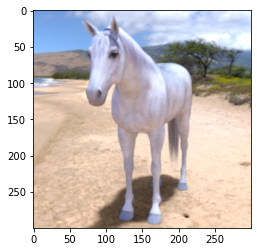


Sample human image:


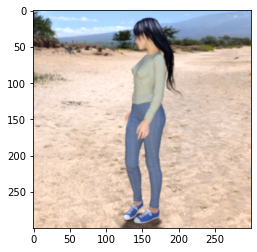

In [11]:
#Check images of each class.

print("Sample horse image:")
plt.imshow(load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}"))
plt.show()

print("\nSample human image:")
plt.imshow(load_img(f"{os.path.join(train_humans_dir, os.listdir(train_humans_dir)[0])}"))
plt.show()

In [12]:
sample_image  = load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (300, 300, 3)


In [13]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

    # Instantiate the ImageDataGenerator class 
    train_datagen = ImageDataGenerator(rescale = 1.0/255)
    train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                      batch_size=32, 
                                                      class_mode='binary',
                                                      target_size=(150, 150))

    validation_datagen = ImageDataGenerator(rescale = 1.0/255)
    validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                batch_size=32, 
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    return train_generator, validation_generator


In [14]:
# Test your generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [16]:
# Download the inception v3 weights
uri_model = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
response_model = requests.get(uri_model)
open('./CV/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5','wb').write(response_model.content)

87910968

In [21]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = './CV/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [22]:
def create_pre_trained_model(local_weights_file):
    
    pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

    pre_trained_model.load_weights(local_weights_file)

    # Make all the layers in the pre-trained model non-trainable
    for layer in pre_trained_model.layers:
        layer.trainable = False

    return pre_trained_model


In [23]:
pre_trained_model = create_pre_trained_model(local_weights_file)
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [24]:
#Check that all the layers were actually non trainable.
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


**Expected Output:**
```
There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.
```

In [25]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

In [26]:
def output_of_last_layer(pre_trained_model):
    
    last_desired_layer = pre_trained_model.get_layer('mixed7')
    print('last layer output shape: ', last_desired_layer.output_shape)
    last_output = last_desired_layer.output
    print('last layer output: ', last_output)

    return last_output


In [27]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [28]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [29]:
#Add layers on top of the pre trained model
def create_final_model(pre_trained_model, last_output):
    
    x = layers.Flatten()(last_output)
    x = layers.Dense(1024, activation='relu')(x)
    
    #Dropout prevents overfitting
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = Model(pre_trained_model.input, x)
    model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

    return model


In [30]:
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


In [31]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/100
33/33 - 30s - loss: 0.0314 - accuracy: 0.9834 - val_loss: 0.1976 - val_accuracy: 0.9453
Epoch 2/100
33/33 - 25s - loss: 6.9175e-05 - accuracy: 1.0000 - val_loss: 0.0692 - val_accuracy: 0.9727

Reached 99.9% accuracy so cancelling training!


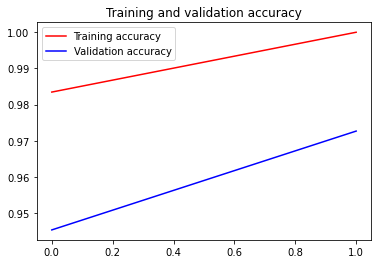

<Figure size 432x288 with 0 Axes>

In [32]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()